# Double DQN

## Installation

In [ ]:
!pip install gymnasium
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]

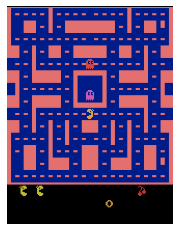

In [33]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array", obs_type="ram")
env.reset()

plt.imshow(env.render())
plt.axis("off");

## Definitions

In [14]:
from torch.nn import Sequential, Linear, ReLU, Module, Conv2d, Flatten

class DQN(Module):

  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.conv = Sequential(
            Conv2d(1, 16, kernel_size=3, stride=3),
            ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=3),
            ReLU(),
            Flatten())


    self.net = Sequential(Linear(12512, hidden_size),
                          ReLU(),
                          Linear(hidden_size, hidden_size),
                          ReLU(),
                          Linear(hidden_size, hidden_size),
                          ReLU(),
                          Linear(hidden_size, n_actions))

  def forward(self, state):
      x = self.conv(state)
      return self.net(x)

In [49]:
from torch.nn import Sequential, Linear, ReLU, Module, Conv2d, Flatten

class DQN(Module):

  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net = Sequential(Linear(obs_size, hidden_size),
                          ReLU(),
                          Linear(hidden_size, hidden_size),
                          ReLU(),
                          Linear(hidden_size, hidden_size),
                          ReLU(),
                          Linear(hidden_size, n_actions))

  def forward(self, state):
      return self.net(state)

In [50]:
import random
import torch
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

In [51]:
from collections import deque

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [52]:
from gymnasium.wrappers import RecordVideo, TimeLimit

def create_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array", obs_type="ram")
  environment = TimeLimit(environment, max_episode_steps=800)
  environment = RecordVideo(environment, video_folder=f'./{name}_recored_episodes', episode_trigger=lambda x: x % 25 == 0, disable_logger=True)

  return environment

In [53]:
def polyak_average(net, target_net, tau=0.01):
  for qp, tp in zip(net.parameters(), target_net.parameters()):
    tp.data.copy_(tau * qp.data + (1 - tau) * tp.data)

In [64]:
from torch.optim import AdamW
from copy import deepcopy
import itertools
from torch.nn.functional import smooth_l1_loss
from torch.utils.data import DataLoader

class DoubleDQN():

  def __init__(self, env_name, nets=None, policy=epsilon_greedy, capacity=10_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, tau=0.05,
               loss_fn=smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=600, samples_per_epoch=1024):

      self.env = create_gym_environment(env_name)

      obs_size = self.env.observation_space.shape[0]
      n_actions = self.env.action_space.n

      self.q_net1 = DQN(hidden_size, obs_size, n_actions) if not nets else nets[0]
      self.q_net2 = DQN(hidden_size, obs_size, n_actions) if not nets else nets[1]

      self.target_q_net1 = deepcopy(self.q_net1)
      self.target_q_net2 = deepcopy(self.q_net2)

      q_net_params = itertools.chain(self.q_net1.parameters(), self.q_net2.parameters())
      self.optim = optim(q_net_params, lr=lr)

      self.policy = policy
      self.buffer = ReplayBuffer(capacity=capacity)
      self.loss_fn = loss_fn

      self.gamma = gamma
      self.tau = tau
      self.batch_size = batch_size
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_last_episode = eps_last_episode
      self.samples_per_epoch = samples_per_epoch
      self.lr = lr

      self.current_epoch = 1
      self.log = []
      self.returns = []
      self.episode_lengths = []

      while len(self.buffer) < self.samples_per_epoch:
        self.play_episode(epsilon=1.0)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
      state = self.env.reset()[0]
      state = torch.tensor(state)/255.0
    
      done = False
      rewards = 0
      episode_length = 0

      while not done:
        if policy:
          action = policy(state.unsqueeze(0), self.env, self.q_net1, epsilon=epsilon)
        else:
          action = self.env.action_space.sample()

        next_state, reward, done1, done2, info = self.env.step(action)
        done = done1 or done2
        rewards += reward
        episode_length += 1

        next_state = torch.tensor(next_state)/255.0
        action, reward, done = list(map(torch.tensor, (action, reward, done)))

        exp = (state, action, reward, done, next_state)
        self.buffer.append(exp)
        state = next_state
      return rewards, episode_length

  def fit(self, n_epoch):
      for epoch in range(n_epoch):
        loss_total = 0
        for _ in range(self.samples_per_epoch//self.batch_size):
          loss = self.training_step()
          loss_total += loss

        last_return, episode_length  = self.training_epoch_end()
        self.returns.append(last_return)
        self.episode_lengths.append(episode_length)
        self.log.append([self.current_epoch, last_return, loss_total.item()])

        if self.current_epoch % 25 == 0:
          print(f"Epoch: {self.current_epoch}, mean return: {np.mean(self.returns[-10:]):.2f}, " \
           f"mean episode length: {np.mean(self.episode_lengths[-10:])}, loss: {loss_total:.2f}")

  def training_step(self):
      batch_T = self.buffer.sample(self.batch_size)
      batch = list(map(torch.stack, zip(*batch_T)))

      states, actions, rewards, dones, next_states = batch
      actions = actions.unsqueeze(1)
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)

      state_action_values1 = self.q_net1(states).gather(1, actions)
      state_action_values2 = self.q_net2(states).gather(1, actions)

      next_action_values1, _ = self.target_q_net1(next_states).max(dim=1, keepdim=True)
      next_action_values2, _ = self.target_q_net2(next_states).max(dim=1, keepdim=True)
      next_action_values = torch.min(next_action_values1, next_action_values2)

      next_action_values = next_action_values1
      next_action_values[dones] = 0.0

      expected_state_action_values = rewards + self.gamma * next_action_values

      loss1 = self.loss_fn(state_action_values1, expected_state_action_values)
      loss2 = self.loss_fn(state_action_values2, expected_state_action_values)
      loss = loss1 + loss2

      self.optim.zero_grad()
      loss.backward()
      self.optim.step()

      return loss

  def training_epoch_end(self):
      epsilon = max(self.eps_end, self.eps_start - self.current_epoch / self.eps_last_episode)

      last_return, episode_length = self.play_episode(policy=self.policy, epsilon=epsilon)

      polyak_average(self.q_net1, self.target_q_net1, tau=self.tau)
      polyak_average(self.q_net2, self.target_q_net2, tau=self.tau)

      self.current_epoch += 1
      return last_return, episode_length

## Training

In [ ]:
algo_double_dqn = DoubleDQN("ALE/MsPacman-v5")
algo_double_dqn.fit(1000)

<AxesSubplot:xlabel='epoch', ylabel='return'>

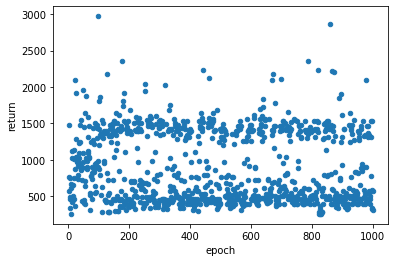

In [79]:
import pandas as pd

df = pd.DataFrame(algo_double_dqn.log, columns=["epoch", "return", "loss"])
df.plot("epoch", "return", kind="scatter")

In [104]:
net1 = algo_double_dqn.q_net1
net2 = algo_double_dqn.q_net2

In [105]:
torch.save(net1, "pacman_qnet1")
torch.save(net2, "pacman_qnet2")

## Testing

In [106]:
q_net1 = torch.load("pacman_qnet1")
q_net2 = torch.load("pacman_qnet2")

In [107]:
from gymnasium.wrappers import RecordVideo, TimeLimit

def create_test_gym_environment():
  environment = gym.make("ALE/MsPacman-v5", render_mode="rgb_array", obs_type="ram")
  environment = TimeLimit(environment, max_episode_steps=800)
  environment = RecordVideo(environment, video_folder=f'./test_MsPacman-v5_recored_episodes', episode_trigger=lambda x: x % 1 == 0, disable_logger=True)

  return environment

In [ ]:
env = create_test_gym_environment()

In [119]:
  @torch.no_grad()
  def play_episode(env, net):
      state = env.reset()[0]
      state = torch.tensor(state)/255.0
    
      done = False
      rewards = 0
      episode_length = 0

      while not done:
        action = epsilon_greedy(state.unsqueeze(0), env, net, epsilon=0.0)
        if random.random() < 0.05:
            action = env.action_space.sample()

        next_state, reward, done1, done2, _ = env.step(action)
        done = done1 or done2
        rewards += reward
        episode_length += 1

        next_state = torch.tensor(next_state)/255.0
        state = next_state
      return rewards, episode_length

In [124]:
for i in range(10):
    rew, el = play_episode(env, q_net2)
    print(f"i: {i}, Reward: {rew}, episode length: {el}")

i: 0, Reward: 1290.0, episode length: 800
i: 1, Reward: 350.0, episode length: 427
i: 2, Reward: 1140.0, episode length: 800
i: 3, Reward: 930.0, episode length: 697
i: 4, Reward: 630.0, episode length: 575
i: 5, Reward: 800.0, episode length: 581
i: 6, Reward: 980.0, episode length: 739
i: 7, Reward: 1060.0, episode length: 609
i: 8, Reward: 990.0, episode length: 625
i: 9, Reward: 460.0, episode length: 459
